In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.patches as patches

from scipy.stats import gaussian_kde as GKDE
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy.integrate as integrate

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.weightedEDFs as wEDFs
import src.distributionsDCI as distDCI
import src.utils as utils

import matplotlib as mpl

In [2]:
plot_directory = './plots'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5

CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 
plt.rcParams['image.cmap'] = 'viridis'

## Problem setup

In [3]:
random.seed(13)
np.random.seed(18)

In [4]:
l = 2.
kappa = 1.

In [5]:
N = 100  # Specify the truncation
ts = [1e-4, 1e-2, 1e-1, 0.4, 0.8]
x = np.linspace(0, l, 2*N)

In [6]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

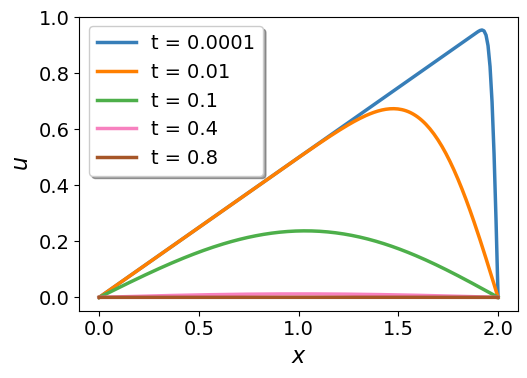

In [8]:
for t in ts:

    u_N = u(N, x, t, l, kappa)
    plt.plot(x, u_N, label='t = ' + str(t));

plt.legend(loc='upper left', shadow=True)
plt.xlabel('$x$')
plt.ylabel('$u$')

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat_eq_sol.png', bbox_inches='tight')

In [9]:
ts = [.01]
sensor_loc = 1.2

## Setup the standard DCI problem

In [10]:
n_sampling_samples = 5000

delta_l = 0.1
delta_kappa = 0.5

sampling_samples = np.random.normal(0, 1, (n_sampling_samples, 2))
sampling_samples[:,1] = np.random.beta(2, 5, (n_sampling_samples)) * 2 + 0.5
sampling_samples[:,0] = sampling_samples[:,0] * delta_l + l

In [11]:
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc, ts[0], XX[count,:], YY[count,:])

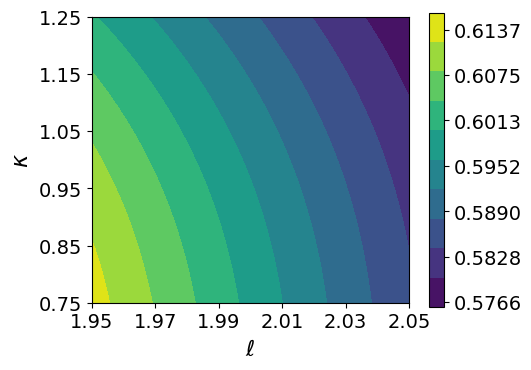

In [13]:
plt.contourf(XX, YY, ZZ, levels=9);
ax = plt.gca()
ax.set_aspect(0.18)

plt.ylabel(r'$\kappa$');
plt.xlabel(r'$\ell$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(ZZ), np.max(ZZ), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(ZZ),
                                                             np.max(ZZ), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/contours.png', bbox_inches='tight')

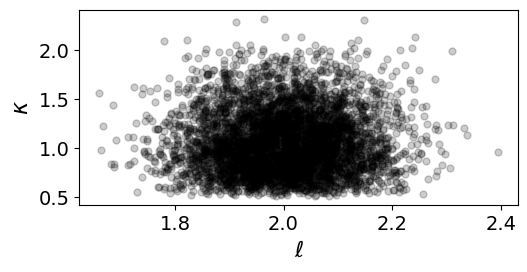

In [14]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], alpha=0.2, color='k')
ax = plt.gca()
ax.set_aspect(0.18)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat_eq_init_samples.png', bbox_inches='tight')

In [15]:
n_init_samples = 3000

init_samples = np.random.uniform(0, 1, (n_init_samples,2))
init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2

init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

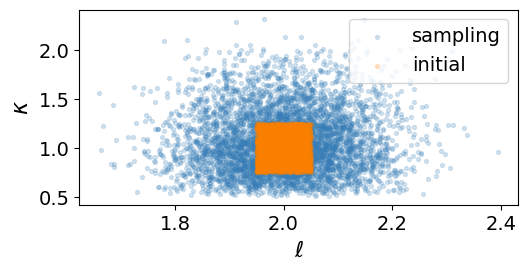

In [17]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], alpha=0.2, label='sampling', s=8)
plt.scatter(init_samples[:,0], init_samples[:,1], alpha=0.2, label='initial', s=8)
ax = plt.gca()
ax.set_aspect(0.18)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.legend()

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_heat_eq_init_samples.png', bbox_inches='tight')

In [18]:
pred_samples = np.zeros((n_init_samples, len(ts)))
for count, t in enumerate(ts):
    pred_samples[:, count] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
    
pred_KDE = GKDE(pred_samples[:,0])

In [19]:
sampling_pred_samples = np.zeros((n_sampling_samples, len(ts)))
for count, t in enumerate(ts):
    sampling_pred_samples[:, count] = u(N, sensor_loc, t, sampling_samples[:,0], sampling_samples[:,1])
    
sampling_pred_KDE = GKDE(sampling_pred_samples[:,0])

In [20]:
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 10000
obs_samples = obs_dist.rvs(n_obs_samples)

obs_KDE = GKDE(obs_samples)

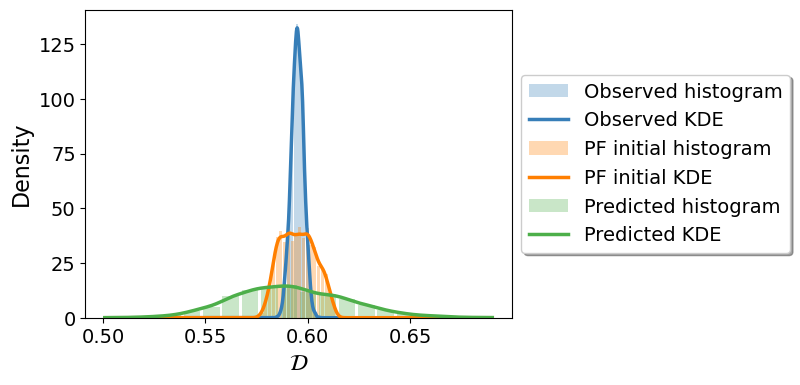

In [21]:
xx = np.linspace(np.min(sampling_pred_samples), np.max(sampling_pred_samples), 1000)

plt.hist(obs_samples, bins=20, alpha=0.3, density=True, label='Observed histogram', rwidth=0.85);
plt.plot(xx, obs_KDE(xx), color=CB_color_cycle[0], label='Observed KDE')

plt.hist(pred_samples, bins=20, alpha=0.3, density=True, label='PF initial histogram', rwidth=0.85);
plt.plot(xx, pred_KDE(xx), color=CB_color_cycle[1], label='PF initial KDE')

plt.hist(sampling_pred_samples, bins=20, alpha=0.3, density=True, label='Predicted histogram', rwidth=0.85);
plt.plot(xx, sampling_pred_KDE(xx), color=CB_color_cycle[2], label='Predicted KDE')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)
plt.xlabel(r'$\mathcal{D}$')
plt.ylabel('Density')

plt.savefig(f'{plot_directory}/niid_heat_eq_dists.png', bbox_inches='tight')

## Density-based solution

In [22]:
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
print(f'E(r) = {np.mean(r)}')

E(r) = 1.0010046285577798


In [24]:
update_inds = utils.rejection_sampling(r)

update_samples = init_samples[update_inds]

pf_samples = pred_samples[update_inds]

pf_KDE = GKDE(pf_samples.T)

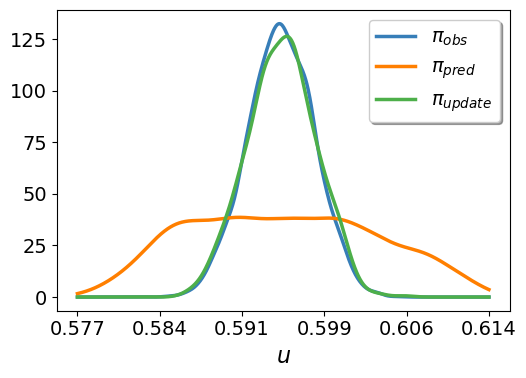

In [25]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$')
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$')
plt.plot(xx, pf_KDE(xx), label=r'$\pi_{update}$')

plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(pred_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(pred_samples), 6)])
plt.xlabel(r'$u$')
plt.legend(shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_dens_results.png', bbox_inches='tight')

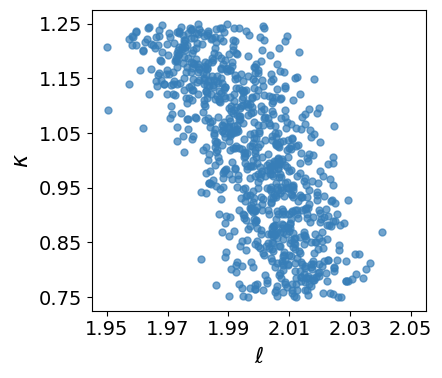

In [26]:
plt.scatter(init_samples[update_inds,0], init_samples[update_inds,1], alpha=0.7)

ax = plt.gca()
ax.set_aspect(0.18)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_rejection.png', bbox_inches='tight')

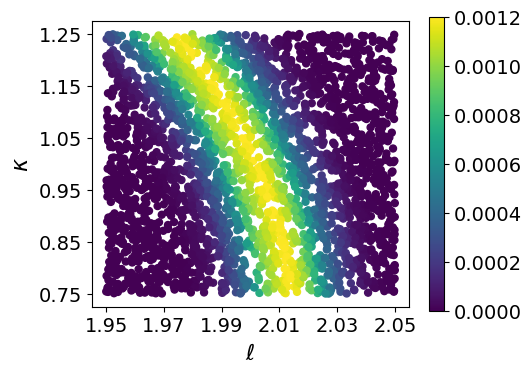

In [27]:
ax = plt.gca()
ax.set_aspect(0.18)

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(r/n_init_samples), np.max(r/n_init_samples), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(r/n_init_samples),
                                                             np.max(r/n_init_samples), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_rn_weights.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22330/2830266873.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])


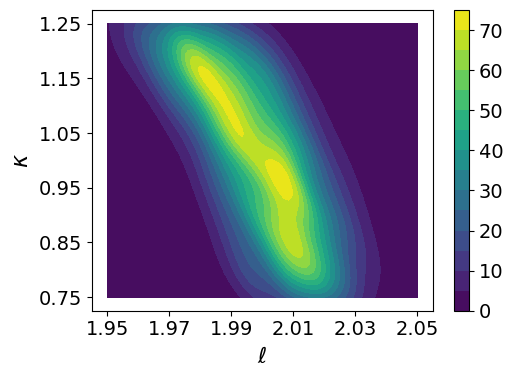

In [28]:
update_KDE = GKDE(init_samples.T, weights=rn_w)
ZZ = np.zeros(np.shape(XX))

for i in range(np.shape(XX)[0]):
    for j in range(np.shape(XX)[1]):
        ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.contourf(XX, YY, ZZ, levels=15);
plt.colorbar()

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_dens_wkde.png', bbox_inches='tight')

In [29]:
n_bins = 40

In [30]:
rpartitioned_w, bins, centers, w_center = distDCI.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                                            pred_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)

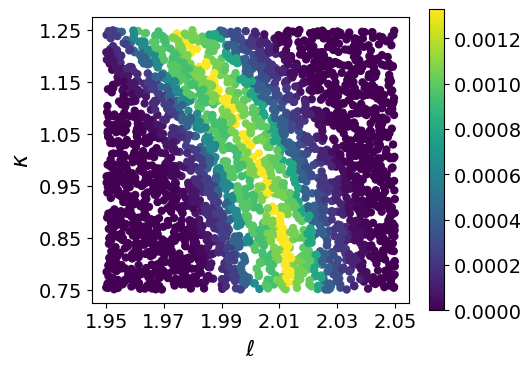

In [31]:
ax = plt.gca()
ax.set_aspect(0.18)

plt.scatter(init_samples[:,0], init_samples[:,1], c=rpartitioned_w)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(r/n_init_samples), np.max(r/n_init_samples), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(r/n_init_samples),
                                                             np.max(r/n_init_samples), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_binning_weights.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22330/1462346162.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])


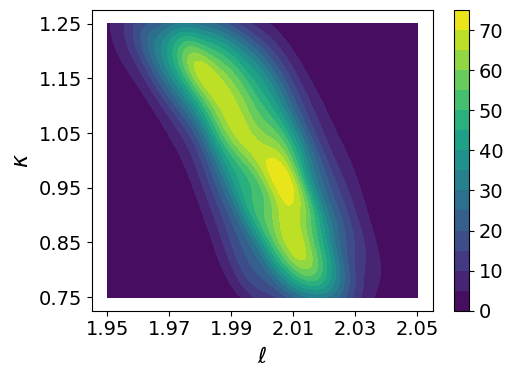

In [33]:
update_KDE = GKDE(init_samples.T, weights=rpartitioned_w)
ZZ = np.zeros(np.shape(XX))

for i in range(np.shape(XX)[0]):
    for j in range(np.shape(XX)[1]):
        ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.contourf(XX, YY, ZZ, levels=15);
plt.colorbar()
plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_bin_wkde.png', bbox_inches='tight')

## Binning methods

In [34]:
n_bins = 200

### Regular partitioning

In [36]:
rpartitioned_w, bins, centers, w_center = distDCI.computePartitionedWeights_regulargrid_nonIID(sampling_samples,
                                                                        sampling_pred_samples,
                                                                        init_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)

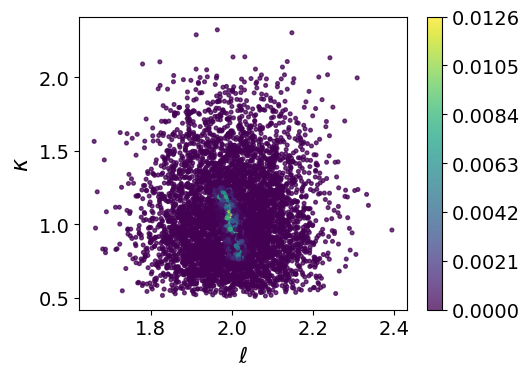

In [37]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], c=rpartitioned_w, alpha=0.75, s=7)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rpartitioned_w),
                                                             np.max(rpartitioned_w), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_regpart_weights.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22330/3224878161.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])


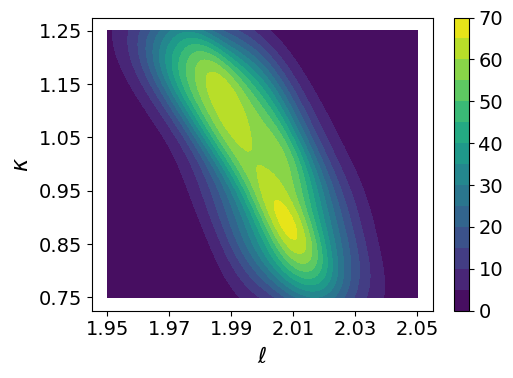

In [38]:
update_KDE = GKDE(sampling_samples.T, weights=rpartitioned_w)
ZZ = np.zeros(np.shape(XX))

for i in range(np.shape(XX)[0]):
    for j in range(np.shape(XX)[1]):
        ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.contourf(XX, YY, ZZ, levels=15);
plt.colorbar()

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_niid_wkde.png', bbox_inches='tight')

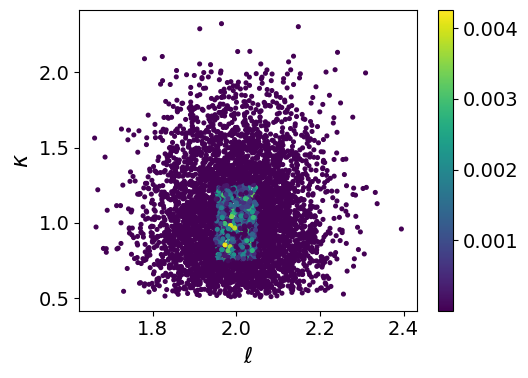

In [39]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], c=centers/len(sampling_samples), s=7)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')

cbar = plt.colorbar()

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_regpart_weights.png', bbox_inches='tight')

In [40]:
samp_KDE = GKDE(sampling_samples.T)

In [41]:
init_KDE = GKDE(init_samples.T)

In [42]:
rn_w = (init_KDE(sampling_samples.T) / samp_KDE(sampling_samples.T)) * (obs_KDE(sampling_pred_samples.T) / pred_KDE(sampling_pred_samples.T))

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22330/1583780994.py:1: RuntimeWarning: invalid value encountered in divide
  rn_w = (init_KDE(sampling_samples.T) / samp_KDE(sampling_samples.T)) * (obs_KDE(sampling_pred_samples.T) / pred_KDE(sampling_pred_samples.T))


In [43]:
print(np.sum(rn_w[~np.isnan(rn_w)])/n_sampling_samples)

1.0500526626863145


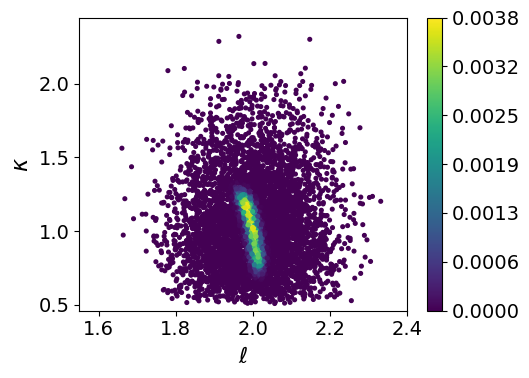

In [44]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], c=rn_w/n_sampling_samples, s=7)

plt.xlim(1.55, 2.4)
plt.ylim(0.46, 2.45)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(rn_w[~np.isnan(rn_w)]), np.max(rn_w[~np.isnan(rn_w)]/n_sampling_samples), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rn_w[~np.isnan(rn_w)]/n_sampling_samples),
                                                             np.max(rn_w[~np.isnan(rn_w)]/n_sampling_samples), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_density.png', bbox_inches='tight')

In [45]:
update_inds = utils.rejection_sampling(rn_w[~np.isnan(rn_w)])

update_samples = sampling_samples[~np.isnan(rn_w)][update_inds]

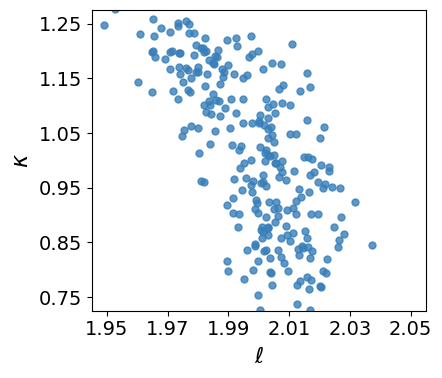

In [46]:
plt.scatter(update_samples[:,0], update_samples[:,1], alpha=0.8)

ax = plt.gca()
ax.set_aspect(0.18)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_rejection.png', bbox_inches='tight')

## Grid search example

In [55]:
n_sampling_samples = 2000

Xs = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 50)
Ys = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 50)

XXs, YYs = np.meshgrid(Xs, Ys)

sampling_samples = np.column_stack([XXs.flatten(), YYs.flatten()])
n_sampling_samples = len(sampling_samples)

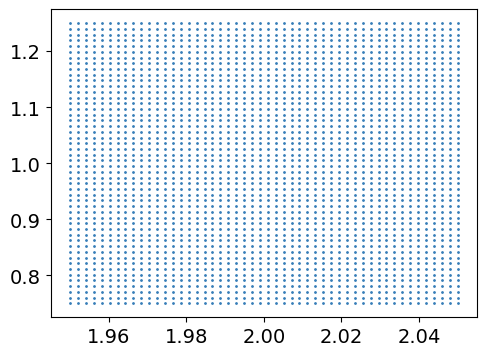

In [56]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], s=1, label='sampling')

In [57]:
n_init_samples = 1000

init_samples = np.zeros((n_init_samples,2))
gen_samples = np.random.beta(2, 5, (n_init_samples,2))
init_samples[:,0] = gen_samples[:,0] * delta_l + l - delta_l / 2
gen_samples = np.random.normal(0.5, 0.15, (n_init_samples,2))
init_samples[:,1] = gen_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

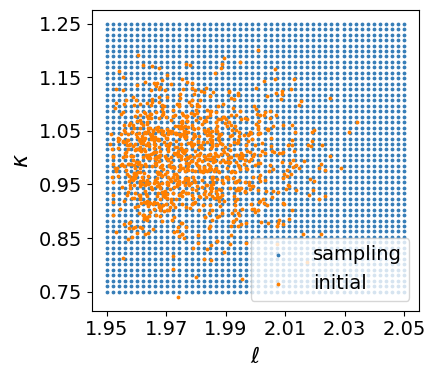

In [58]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], label='sampling', s=3)
plt.scatter(init_samples[:,0], init_samples[:,1], label='initial', s=3)
ax = plt.gca()
ax.set_aspect(0.18)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.legend(facecolor=(1, 1, 1, 1))

plt.tight_layout()
plt.savefig(f'{plot_directory}/gsearch_heat_eq_init_samples.png', bbox_inches='tight')

In [59]:
pred_samples = np.zeros((n_sampling_samples, len(ts)))
for count, t in enumerate(ts):
    pred_samples[:, count] = u(N, sensor_loc, t, sampling_samples[:,0], sampling_samples[:,1])

pred_KDE = GKDE(pred_samples[:,0])

In [60]:
init_pred_samples = np.zeros((n_init_samples, len(ts)))
for count, t in enumerate(ts):
    init_pred_samples[:, count] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
    
init_pred_KDE = GKDE(init_pred_samples[:,0])

In [61]:
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 10000
obs_samples = obs_dist.rvs(n_obs_samples)

obs_KDE = GKDE(obs_samples)

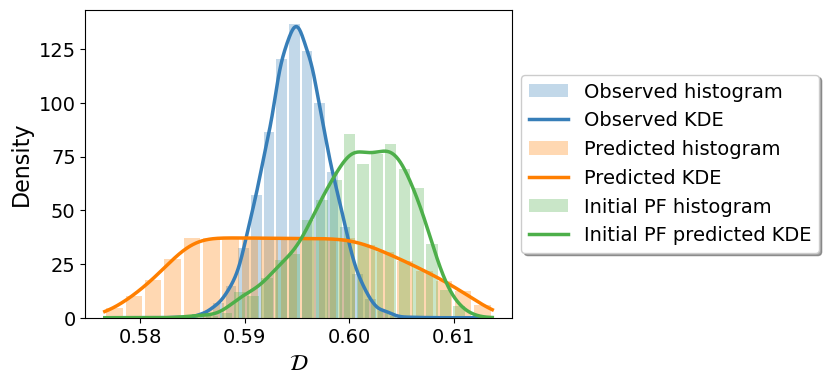

In [66]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)

plt.hist(obs_samples, bins=20, alpha=0.3, density=True, label='Observed histogram', rwidth=0.85);
plt.plot(xx, obs_KDE(xx), color=CB_color_cycle[0], label='Observed KDE')

plt.hist(pred_samples, bins=20, alpha=0.3, density=True, label='Predicted histogram', rwidth=0.85);
plt.plot(xx, pred_KDE(xx), color=CB_color_cycle[1], label='Predicted KDE')

plt.hist(init_pred_samples, bins=20, alpha=0.3, density=True, label='Initial PF histogram', rwidth=0.85);
plt.plot(xx, init_pred_KDE(xx), color=CB_color_cycle[2], label='Initial PF predicted KDE')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)
plt.xlabel(r'$\mathcal{D}$')
plt.ylabel('Density')

plt.savefig(f'{plot_directory}/gsearch_heat_eq_dists.png', bbox_inches='tight')

In [67]:
r = obs_KDE(init_pred_samples.T) / init_pred_KDE(init_pred_samples.T)
rn_w = r / n_init_samples
print(f'E(r) = {np.mean(r)}')

E(r) = 0.9793925744848554


In [69]:
update_inds = utils.rejection_sampling(r)

update_samples = init_samples[update_inds]

pf_samples = init_pred_samples[update_inds]

pf_KDE = GKDE(pf_samples.T)

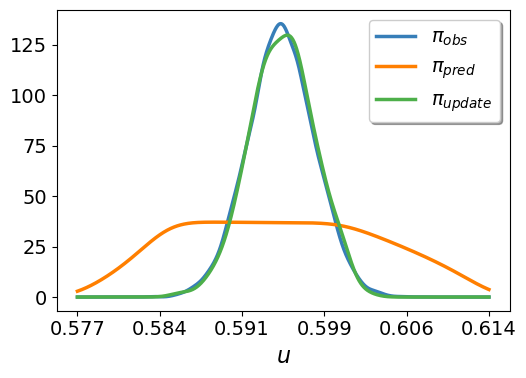

In [71]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$')
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$')
plt.plot(xx, pf_KDE(xx), label=r'$\pi_{update}$')

plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(pred_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(pred_samples), 6)])
plt.xlabel(r'$u$')
plt.legend(shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/niid_dens_results.png', bbox_inches='tight')

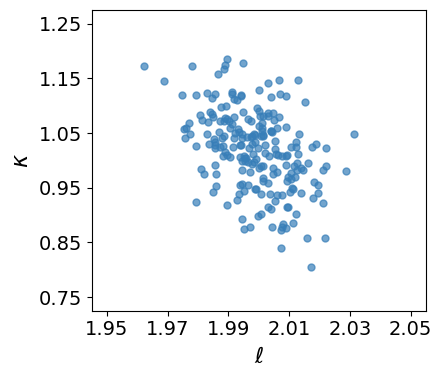

In [72]:
plt.scatter(init_samples[update_inds,0], init_samples[update_inds,1], alpha=0.7)

ax = plt.gca()
ax.set_aspect(0.18)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/gsearch_rejection.png', bbox_inches='tight')

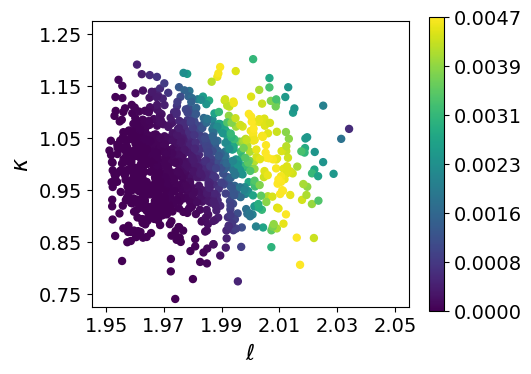

In [73]:
ax = plt.gca()
ax.set_aspect(0.18)

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(r/n_init_samples), np.max(r/n_init_samples), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(r/n_init_samples),
                                                             np.max(r/n_init_samples), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/gsearch_rn_weights.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22330/1944546545.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])


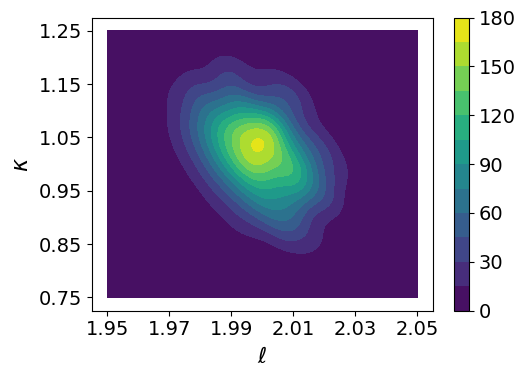

In [74]:
update_KDE = GKDE(init_samples.T, weights=rn_w)
ZZ = np.zeros(np.shape(XX))

for i in range(np.shape(XX)[0]):
    for j in range(np.shape(XX)[1]):
        ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.contourf(XX, YY, ZZ, levels=15);
plt.colorbar()

plt.tight_layout()
plt.savefig(f'{plot_directory}/gsearch_dens_wkde.png', bbox_inches='tight')

In [75]:
n_bins = 20

In [76]:
rpartitioned_w, bins, centers, w_center = distDCI.computePartitionedWeights_regulargrid_nonIID(sampling_samples,
                                                                        pred_samples,
                                                                        init_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)

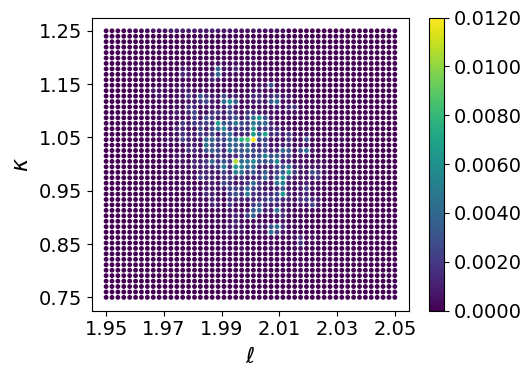

In [77]:
plt.scatter(sampling_samples[:,0], sampling_samples[:,1], c=rpartitioned_w, s=6)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rpartitioned_w),
                                                             np.max(rpartitioned_w), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/gsearch_regpart_weights.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22330/2774002587.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])


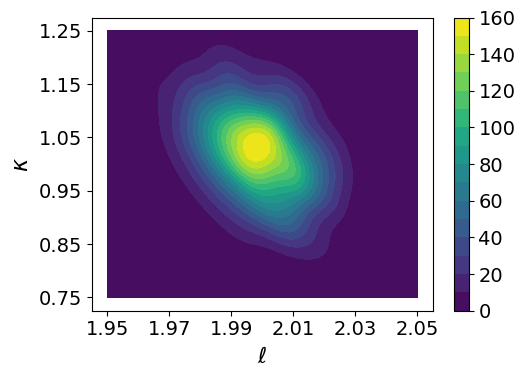

In [78]:
update_KDE = GKDE(sampling_samples.T, weights=rpartitioned_w)
ZZ = np.zeros(np.shape(XX))

for i in range(np.shape(XX)[0]):
    for j in range(np.shape(XX)[1]):
        ZZ[i,j] = update_KDE([XX[i,j], YY[i,j]])

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])
plt.contourf(XX, YY, ZZ, levels=15);
plt.colorbar()

plt.tight_layout()
plt.savefig(f'{plot_directory}/gsearch_niid_wkde.png', bbox_inches='tight')